In [50]:
import requests
from bs4 import BeautifulSoup
import json
from copy import deepcopy
import pandas as pd
import re
import matplotlib.pyplot as plt

In [51]:
class Dados_ChavesNaMao:
    def __init__(self, url):

        self.url = url

    def coleta_dados(self):

        # Fazendo a requisição para a página
        response = requests.get(self.url)
        site = BeautifulSoup(response.text, "html.parser")

        #Coleta de dados
        bairro = []
        preco_imovel = []
        for tag_b in site.find_all("b")[1:]:
            texto = tag_b.text.strip()
            if not texto.startswith("R$") and "+" not in texto:
                bairro.append(texto)
            if texto.startswith("R$") and "+" not in texto:

                preco_imovel.append(texto)
                
        # Removendo "R$" dos valores de preco_imovel e pontos
        preco_imovel = [p.replace("R$ ", "") for p in preco_imovel]
        preco_imovel = [p.replace(".","") for p in preco_imovel]

        #Removendo Florianópolis dos dados do bairro
        bairro = [b.replace(", Florianópolis", "") for b in bairro]

        # Criando uma lista de dicionários combinando bairro e preco_imovel
        imoveis = [{"bairro": b, "preco_imovel": p} for b, p in zip(bairro, preco_imovel)]

        # Convertendo para JSON
        json_bairro_preco = json.dumps(imoveis, indent=2, ensure_ascii=False)

        # Criando uma lista de dicionários para informações locais
        info_locais = []
        for text_line in site.find_all("ul")[1:]:
            if text_line.get("class") != ["list", "im"]:
                continue
            else:
                # Obtém o texto dentro da <ul>
                line_text = text_line.text.strip()

                # Usando expressões regulares para extrair informações
                tamanho_match = re.search(r'([\d.]+)m²', line_text)
                quartos_match = re.search(r'(\d+)\s*Quarto', line_text) 
                banheiros_match = re.search(r'(\d+)\s*Banheiro', line_text)
                garagens_match = re.search(r'(\d+)\s*Garagem', line_text) or re.search(r'(\d+)\s*Garagens', line_text)

                # Extraindo os valores ou define como zero se não encontrados
                tamanho = float(tamanho_match.group(1).replace(".", "")) if tamanho_match else 0
                quartos = int(quartos_match.group(1)) if quartos_match else 0
                banheiros = int(banheiros_match.group(1)) if banheiros_match else 0
                garagens = int(garagens_match.group(1)) if garagens_match else 0

                # Adicionando as informações à lista
                valores = {"Tamanho": tamanho,
                        "Quartos": quartos,
                        "Banheiros": banheiros,
                        "Garagens": garagens}
                info_locais.append(valores)

        # Encontrando informações a partir das tags <h2> desejadas
        tags_h2 = site.find_all("h2")
        legendas_totais = [tag_h2.text for tag_h2 in tags_h2]
    
        # Encontrando informações a partir das tags <a> desejadas
        tags_a = site.find_all("a", class_="containerSlider slider")
        links = [tag_a.get("href") for tag_a in tags_a]

        # Concatenando os dados de imoveis, info_locais e legendas
        imoveis_combinados = []
        for detalhe, info_local, legenda, link in zip(imoveis, info_locais, legendas_totais, links):
            # Criando uma cópia do dicionário de detalhe
            imovel_combinado = detalhe.copy()

            # Adicionando as informações de info_local e legenda ao dicionário
            imovel_combinado.update(info_local)
            imovel_combinado["Legenda"] = legenda
            imovel_combinado["Link"] = link
            # Adicionando o dicionário combinado à lista
            imoveis_combinados.append(imovel_combinado)
        
        # Convertendo para JSON
        json_combinado = json.dumps(imoveis_combinados, indent=2, ensure_ascii=False)

        # Imprimindo o resultado JSON combinado
        df = pd.read_json(json_combinado)
        
        return df
    

    def tamanho_versus_preco_bairro(self, df, bairro):

        # Filtrando os dados para o bairro específico
        df_analisado = df[df["bairro"] == bairro]

        # Convertendo as colunas "Tamanho" e "preco_imovel" para numérico
        df_analisado["Tamanho"] = pd.to_numeric(df_analisado["Tamanho"], errors='coerce')
        df_analisado["preco_imovel"] = pd.to_numeric(df_analisado["preco_imovel"], errors='coerce')

        # Configurando o tamanho da figura
        plt.figure(figsize=(10, 6))

        # Plotando o gráfico de dispersão
        plt.scatter(df_analisado["Tamanho"], df_analisado["preco_imovel"])

        # Definindo os limites do eixo x para um intervalo específico (por exemplo, 0 a 2000 m²)
        plt.xlim(0, 500)

        # Adicionando rótulos e título ao gráfico
        plt.xlabel("Tamanho (m²)")
        plt.ylabel("Preço do Imóvel")
        plt.title(f"Gráfico de Dispersão: Tamanho vs. Preço do Imóvel (Bairro {bairro})")

        # Exibindo o gráfico
        plt.show()

In [52]:
url = 'https://www.chavesnamao.com.br/imoveis/sc-florianopolis/' #URL do site com a sua cidade selecionada
contador = 2 # É utilizado apenas a partir da segunda página

#Primeira página
df_ChavesNaMao = Dados_ChavesNaMao(url=url)
df_ChavesNaMao = df_ChavesNaMao.coleta_dados()

# Itera sobre as páginas seguintes
while True:
    iter_url = url + f"?pg={contador}"
    dados = Dados_ChavesNaMao(url=iter_url)
    df_iter = dados.coleta_dados()

    # Verificando se há dados na página
    if not df_iter.empty:
        # Concatenando os DataFrames
        df_ChavesNaMao = pd.concat([df_ChavesNaMao, df_iter], ignore_index=True)
        contador += 1
    else:
        # Se não houver mais dados, interrompe o loop
        break

# Removendo linhas com "Confira" na coluna "preco_imovel"
df_ChavesNaMao = df_ChavesNaMao[df_ChavesNaMao["preco_imovel"] != "Confira"]

# Removendo duplicatas
dados_acumulados = df_ChavesNaMao.drop_duplicates()

# Removendo espaços no início e no final da coluna "bairro"
df_ChavesNaMao["bairro"] = df_ChavesNaMao["bairro"].str.strip()

# Removendo espaços extras no meio da coluna "bairro"
df_ChavesNaMao["bairro"] = df_ChavesNaMao["bairro"].str.replace(r'\s+', ' ', regex=True)

df_ChavesNaMao = df_ChavesNaMao.applymap(lambda x: x.strip() if isinstance(x, str) else x)


# Convertendo a coluna "preco_imovel" para numérico
df_ChavesNaMao["preco_imovel"] = pd.to_numeric(df_ChavesNaMao["preco_imovel"], errors='coerce')

#Removendo outliers (Imóveis alugando ou terrenos muito grandes)
df_ChavesNaMao = df_ChavesNaMao[(df_ChavesNaMao["preco_imovel"] > 20000) & (df_ChavesNaMao["preco_imovel"] < 8000000)]


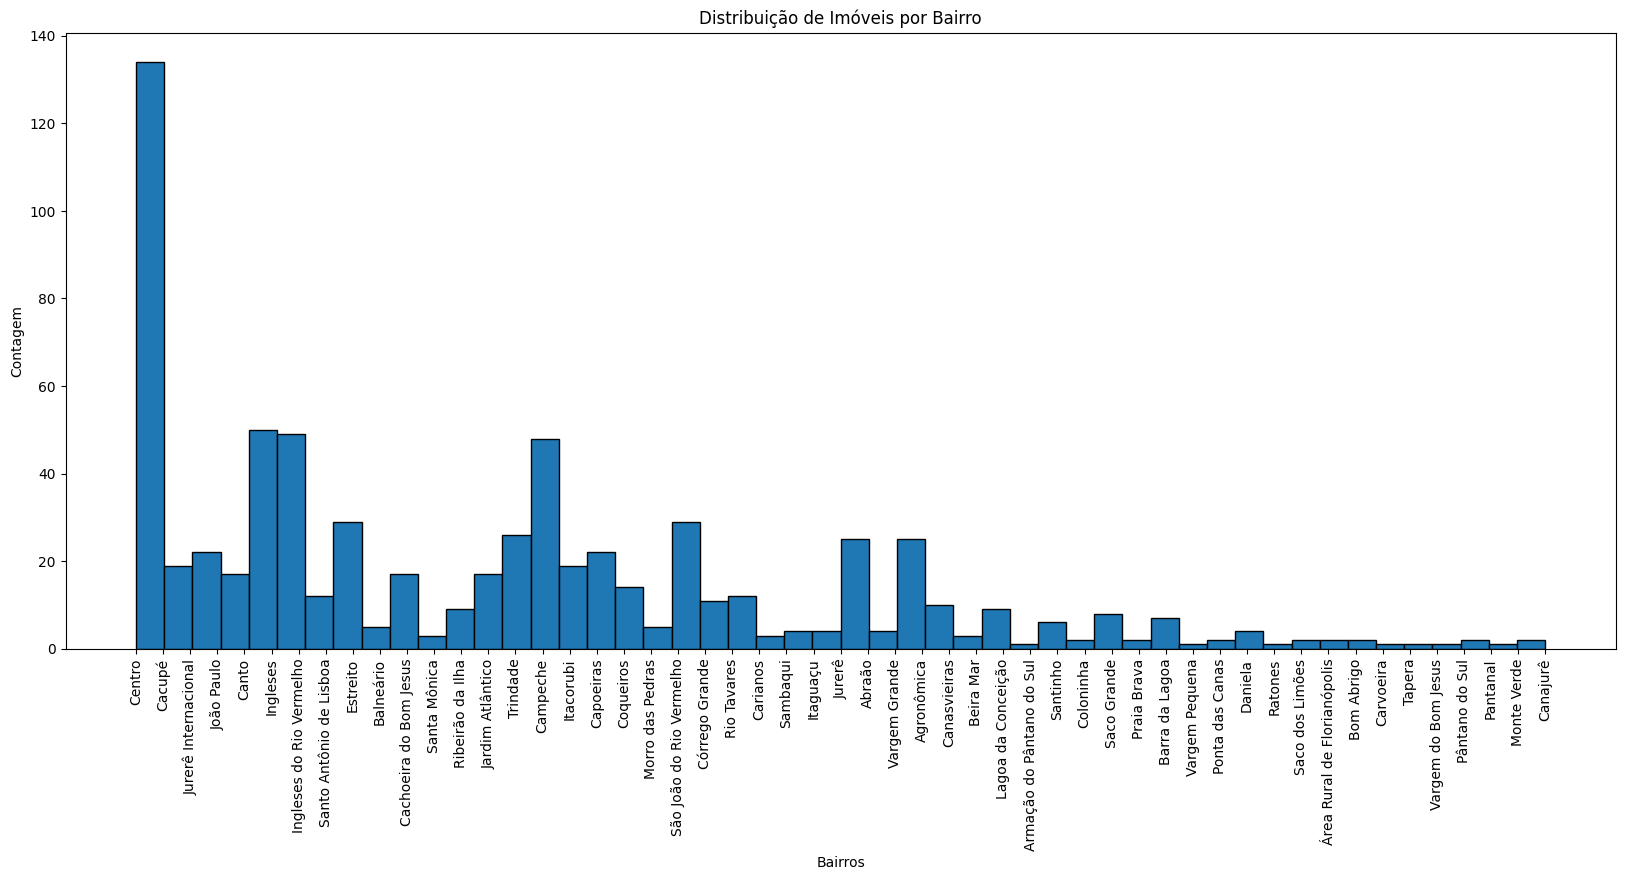

In [54]:
import matplotlib.pyplot as plt

# Configurações para garantir que os rótulos dos bairros não se sobreponham
plt.figure(figsize=(20, 8))
plt.xticks(rotation=90)

# Criando o histograma
plt.hist(df_ChavesNaMao["bairro"], bins=50, edgecolor='black')

# Adicionando rótulos e título
plt.xlabel('Bairros')
plt.ylabel('Contagem')
plt.title('Distribuição de Imóveis por Bairro')

# Exibir o histograma
plt.show()


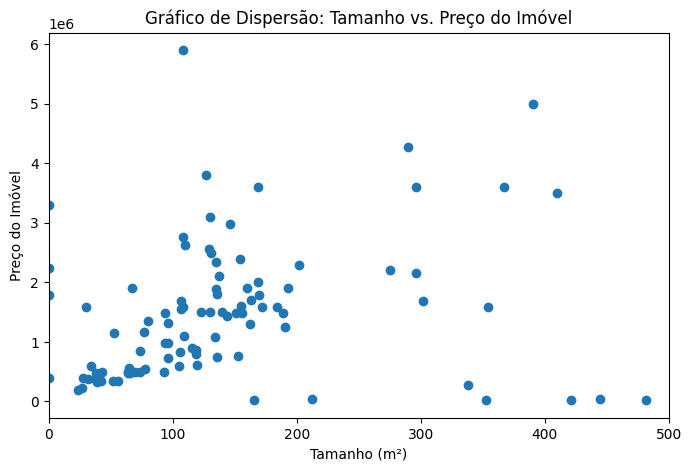

In [55]:
# Filtrando os dados para o bairro "Centro"
df_centro = df_ChavesNaMao.loc[df_ChavesNaMao["bairro"] == "Centro"].copy()
df_centro["Tamanho"] = pd.to_numeric(df_centro["Tamanho"], errors='coerce')
df_centro["preco_imovel"] = pd.to_numeric(df_centro["preco_imovel"], errors='coerce')

# Configurando o tamanho da figura
plt.figure(figsize=(8, 5))

# Plotando o gráfico de dispersão
plt.scatter(df_centro["Tamanho"], df_centro["preco_imovel"])

# Definindo os limites do eixo x para um intervalo específico (por exemplo, 0 a 500 m²)
plt.xlim(0, 500)

# Adicionando rótulos e título ao gráfico
plt.xlabel("Tamanho (m²)")
plt.ylabel("Preço do Imóvel")
plt.title("Gráfico de Dispersão: Tamanho vs. Preço do Imóvel")

# Exibindo o gráfico
plt.show()


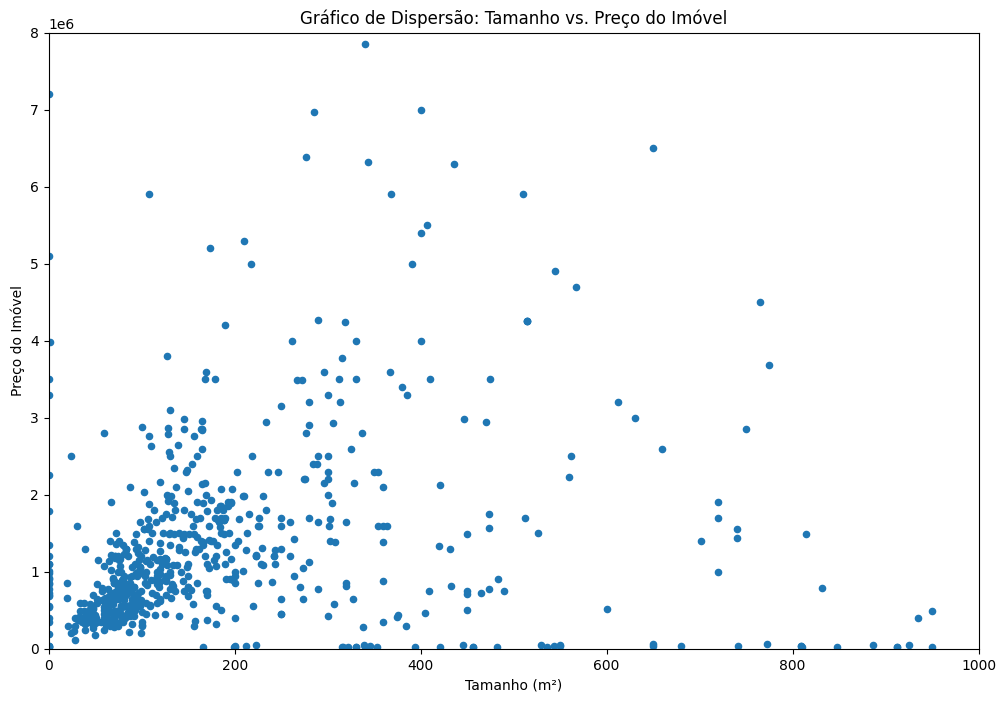

In [56]:
# Configurando o tamanho da figura
plt.figure(figsize=(12, 8))

# Plotando o gráfico de dispersão
plt.scatter(df_ChavesNaMao["Tamanho"], df_ChavesNaMao["preco_imovel"], s=20)

# Definindo os limites do eixo x para um intervalo específico (por exemplo, 0 a 500 m²)
plt.xlim(0, 1000)
plt.ylim(0,8000000)

# Adicionando rótulos e título ao gráfico
plt.xlabel("Tamanho (m²)")
plt.ylabel("Preço do Imóvel")
plt.title("Gráfico de Dispersão: Tamanho vs. Preço do Imóvel")

# Exibindo o gráfico
plt.show()